In [7]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load data
df = pd.read_csv("/content/drive/MyDrive/framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
print("Số Dòng Dữ Liệu: ",df.shape[0])
print("Số Cột Dữ Liệu: ",df.shape[1])

Số Dòng Dữ Liệu:  4240
Số Cột Dữ Liệu:  16


# **EDA**

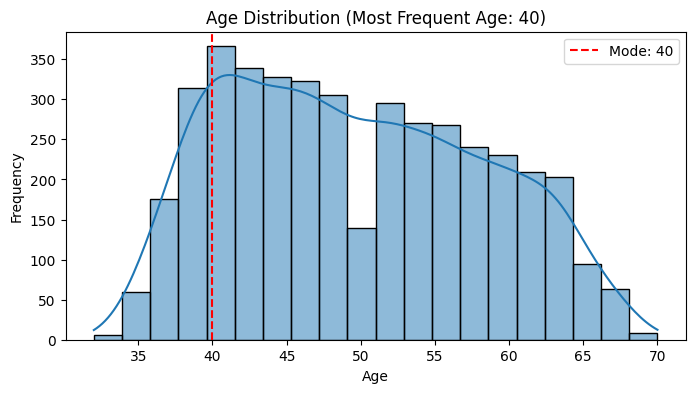

In [8]:
# Most frequent age
most_frequent_age = df['age'].mode().values[0]

plt.figure(figsize=(8, 4))
ax = sns.histplot(df['age'], bins=20, kde=True)
ax.set_title(f'Age Distribution (Most Frequent Age: {most_frequent_age})')
ax.set(xlabel='Age', ylabel='Frequency')

plt.axvline(most_frequent_age, color='red', linestyle='--', label=f'Mode: {most_frequent_age}')
plt.legend()


<ipython-input-9-119756dedfab>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='male', palette='pastel')
<ipython-input-9-119756dedfab>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Female', 'Male'])


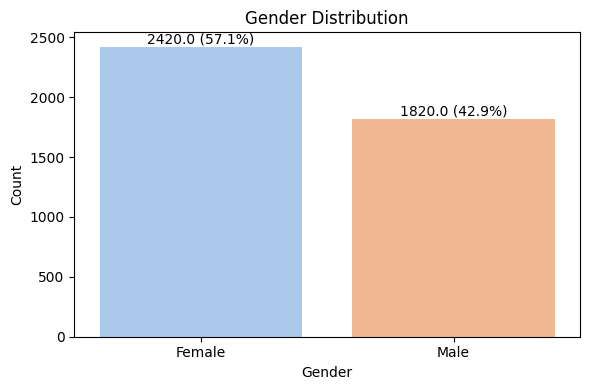

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='male', palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

total_count = len(df)

for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total_count
    label = f'{count} ({percentage:.1f}%)'
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10)

ax.set_xticklabels(['Female', 'Male'])

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Correlation Heatmap of Numeric Features')

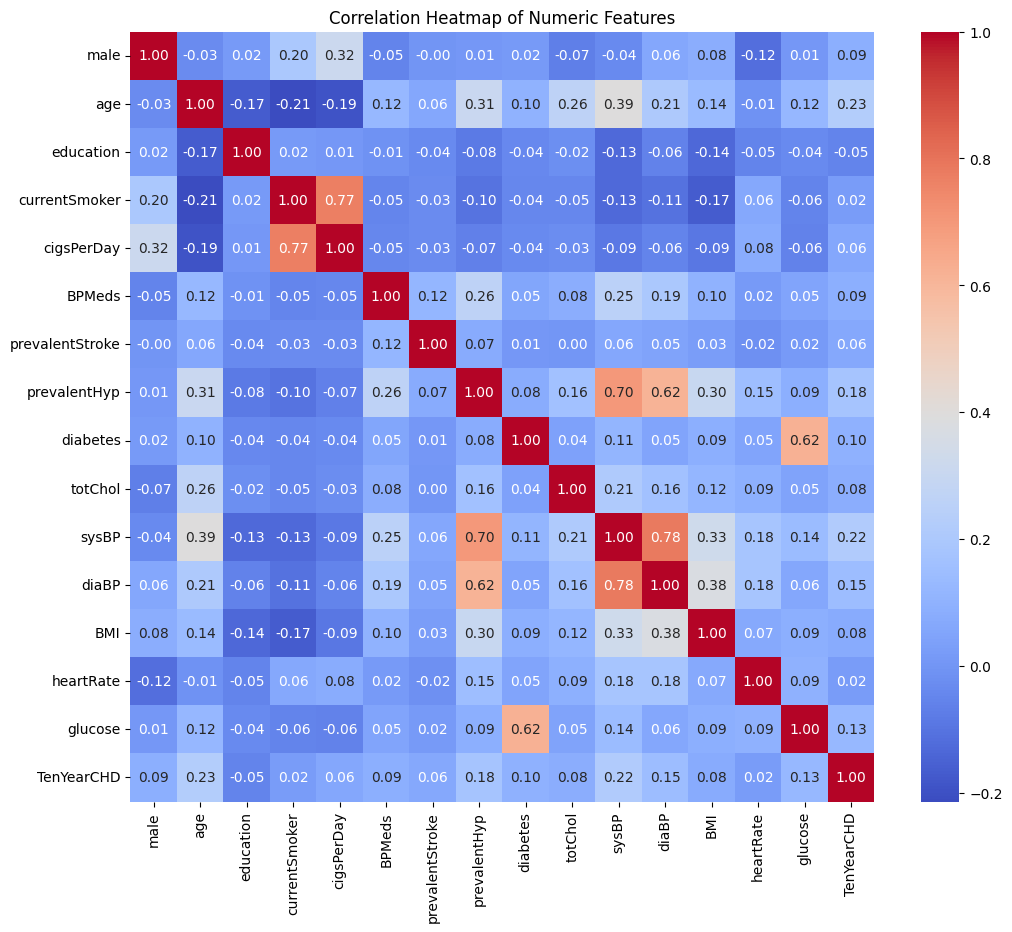

In [10]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')

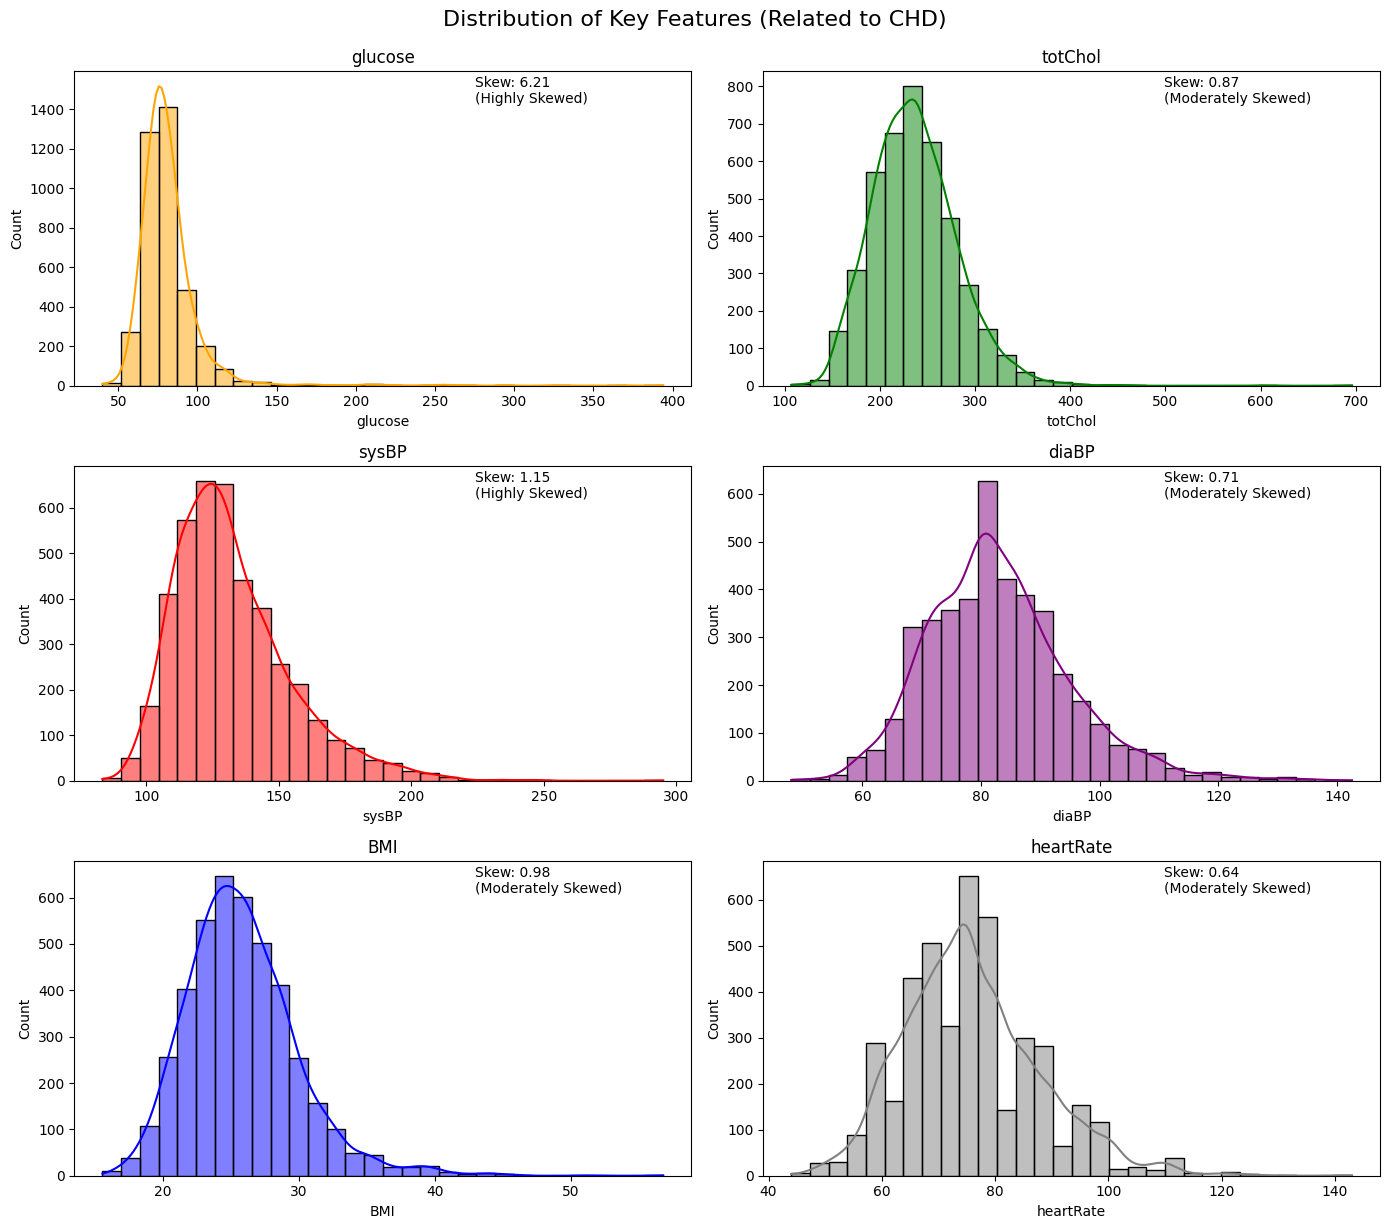

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['glucose', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate']
colors = ['orange', 'green', 'red', 'purple', 'blue', 'grey']

def get_skew_label(skewness):
    if skewness < -1 or skewness > 1:
        return 'Highly Skewed'
    elif (-1 <= skewness <= -0.5) or (0.5 <= skewness <= 1):
        return 'Moderately Skewed'
    else:
        return 'Approximately Symmetric'

plt.figure(figsize=(14, 12))

for i, var in enumerate(variables):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[var].dropna(), color=colors[i], kde=True, bins=30)
    plt.title(f'{var}')

    skewness = df[var].skew()
    skew_label = get_skew_label(skewness)
    plt.text(0.65, 0.9, f'Skew: {skewness:.2f}\n({skew_label})', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.suptitle('Distribution of Key Features (Related to CHD)', fontsize=16, y=1.02)
plt.show()


# **Preprocessing**

In [ ]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
male,2
age,39
education,4
currentSmoker,2
cigsPerDay,33
BPMeds,2
prevalentStroke,2
prevalentHyp,2
diabetes,2
totChol,248


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [12]:
df.drop(['education'], inplace = True, axis = 1)

In [13]:
df.isnull().sum()

,0
male,0
age,0
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50
sysBP,0


In [14]:
from sklearn.impute import SimpleImputer

df.loc[(df['currentSmoker'] == 0) & (df['cigsPerDay'].isnull()), 'cigsPerDay'] = 0
median_smoker = df.loc[df['currentSmoker'] == 1, 'cigsPerDay'].median()
df['cigsPerDay'].fillna(median_smoker, inplace=True)

df['BPMeds'].fillna(0, inplace=True)

numeric_imputer = SimpleImputer(strategy='median')
df[['totChol', 'BMI', 'heartRate']] = numeric_imputer.fit_transform(df[['totChol', 'BMI', 'heartRate']])

df['glucose'].fillna(df['glucose'].median(), inplace=True)



<ipython-input-14-ac5e0d52160d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cigsPerDay'].fillna(median_smoker, inplace=True)
<ipython-input-14-ac5e0d52160d>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [15]:
df.isnull().sum()


,0
male,0
age,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0
sysBP,0


# Training Model

In [16]:
X = np.asarray(df.drop(columns=['TenYearCHD', 'currentSmoker']))
y = np.asarray(df['TenYearCHD'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3392, 13) (3392,)
Test set: (848, 13) (848,)


In [17]:
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (3392, 13)
The shape of X_test is        (848, 13)
The shape of y_train is       (3392,)
The shape of y_test is        (848,)


In [18]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression & SVM (sklearn)**

In [ ]:
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

# SVM Classifier
svm_model = SVC(kernel='rbf', C=1.0, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate both
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


Logistic Regression Accuracy: 0.8561320754716981
SVM Accuracy: 0.8525943396226415


In [19]:
import plotly.express as px
import pandas as pd

def visualize_tuning_results(grid, model_name, score_metric='mean_test_score'):

    results_df = pd.DataFrame(grid.cv_results_)

    param_cols = [col for col in results_df.columns if col.startswith('param_')]
    selected_cols = param_cols + [score_metric]
    vis_df = results_df[selected_cols].copy()

    vis_df['Score'] = vis_df[score_metric]
    vis_df.drop(columns=[score_metric], inplace=True)

    str_mappings = {}

    for col in param_cols:
        if vis_df[col].dtype == 'object' or isinstance(vis_df[col].iloc[0], str):
            unique_vals = vis_df[col].unique()
            mapping = {val: idx for idx, val in enumerate(unique_vals)}
            str_mappings[col] = mapping
            vis_df[col] = vis_df[col].map(mapping)

    vis_df.rename(columns={col: col.replace('param_', '') for col in vis_df.columns}, inplace=True)

    fig = px.parallel_coordinates(
        vis_df,
        color='Score',
        labels={col.replace('param_', ''): col.replace('param_', '') for col in param_cols} | {'Score': 'Accuracy'},
        title=f"Biểu đồ trực quan hóa tuning - {model_name}",
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig.show()

    if str_mappings:
        print(f"\nÁnh xạ giá trị chuỗi -> số cho {model_name}:")
        for col, mapping in str_mappings.items():
            print(f" - {col.replace('param_', '')}: {mapping}")


**Tuning hyper parameter for SVM**

In [ ]:
param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.05, 0.1, 0.5, 1]
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.05, 0.1, 0.5, 1]
    }
]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.8484666414691047


TypeError: visualize_tuning_results() got an unexpected keyword argument 'loss_metric'

In [ ]:
visualize_tuning_results(grid_search, model_name="SVM", score_metric='mean_test_score')



Ánh xạ giá trị chuỗi -> số cho SVM:
 - kernel: {'linear': 0, 'rbf': 1, 'sigmoid': 2}


**Logistic Regression (from scratch)**

In [ ]:
import numpy as np

# Hàm sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Hàm mất mát - Binary Cross-Entropy
def compute_loss(y, y_pred):
    epsilon = 1e-15  # tránh log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

# Lớp Logistic Regression
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Khởi tạo tham số
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for i in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = sigmoid(linear_model)

            # Gradient
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Cập nhật tham số
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_prob(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)

    def predict(self, X):
        y_pred_prob = self.predict_prob(X)
        return np.where(y_pred_prob >= 0.5, 1, 0)

# Huấn luyện mô hình từ đầu
log_model = LogisticRegressionScratch(learning_rate=0.1, n_iters=1000)
log_model.fit(X_train_scaled, y_train)

# Dự đoán
y_pred_log = log_model.predict(X_test_scaled)

correct = sum(y_pred_log[i] == y_test[i] for i in range(len(y_test)))
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")



Accuracy: 0.8561320754716981


**SVM scratch**

In [ ]:
import numpy as np

def rbf_kernel(x1, x2, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2)**2)

def svm_optimization(X, y, kernel, C=1.0, tol=1e-3, max_passes=5):
    m, n = X.shape
    alphas = np.zeros(m)
    b = 0
    passes = 0
    K = kernel(X, X)

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            Ei = np.sum(alphas * y * K[:, i]) + b - y[i]
            if (y[i]*Ei < -tol and alphas[i] < C) or (y[i]*Ei > tol and alphas[i] > 0):
                j = np.random.choice([k for k in range(m) if k != i])
                Ej = np.sum(alphas * y * K[:, j]) + b - y[j]
                alpha_i_old, alpha_j_old = alphas[i], alphas[j]

                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[i] + alphas[j] - C)
                    H = min(C, alphas[i] + alphas[j])
                if L == H:
                    continue

                eta = 2 * K[i,j] - K[i,i] - K[j,j]
                if eta >= 0:
                    continue

                alphas[j] -= y[j] * (Ei - Ej) / eta
                alphas[j] = np.clip(alphas[j], L, H)
                if abs(alphas[j] - alpha_j_old) < 1e-5:
                    continue

                alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])
                b1 = b - Ei - y[i] * (alphas[i] - alpha_i_old) * K[i,i] - y[j] * (alphas[j] - alpha_j_old) * K[i,j]
                b2 = b - Ej - y[i] * (alphas[i] - alpha_i_old) * K[i,j] - y[j] * (alphas[j] - alpha_j_old) * K[j,j]
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    return alphas, b

class CustomSVM:
    def __init__(self, C=1.0, gamma=1.0):
        self.C = C
        self.gamma = gamma
        self.alphas = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.kernel = lambda x1, x2: rbf_kernel(x1, x2, gamma=self.gamma)

    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)  # Convert labels from 0/1 to -1/+1
        self.X = X
        self.y = y
        self.alphas, self.b = svm_optimization(X, y, self.kernel, self.C)
        support_idx = np.where(self.alphas > 1e-5)[0]
        self.support_vectors = X[support_idx]
        self.support_vector_labels = y[support_idx]
        self.alphas = self.alphas[support_idx]

    def predict(self, X):
        K = self.kernel(self.support_vectors, X)
        y_pred = np.sum(self.alphas[:, None] * self.support_vector_labels[:, None] * K, axis=0) + self.b
        return (np.sign(y_pred) + 1) // 2  # Convert -1/+1 to 0/1

svm_model = CustomSVM(C=1.0, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

correct = sum(y_pred[i] == y_test[i] for i in range(len(y_test)))
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8525943396226415


**Decision Tree & Random Forest (sklearn)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='sqrt', random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Decision Tree Accuracy: 0.847877358490566
Random Forest Accuracy: 0.8537735849056604


**Tuning hyper parameter for Random Forest**

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200, 400, 600, 800, 1000],
    'max_depth': [None, 3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

visualize_tuning_results(grid_search, model_name='Random Forest', score_metric='mean_test_score')



Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 600}
Best score: 0.8516509433962265



Ánh xạ giá trị chuỗi -> số cho Random Forest:
 - max_depth: {None: 0, 3: 1, 5: 2, 7: 3}
 - max_features: {'sqrt': 0, 'log2': 1}


**Randomforest and decision tree scratch**

In [ ]:
import numpy as np
from collections import Counter
import random

import numpy as np
from collections import Counter

class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

def gini(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return 1 - np.sum(ps ** 2)

def split(X, y, feat_idx, threshold):
    left_idxs = X[:, feat_idx] <= threshold
    right_idxs = X[:, feat_idx] > threshold
    return X[left_idxs], y[left_idxs], X[right_idxs], y[right_idxs]

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, n_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        self.n_features = X.shape[1] if self.n_features is None else self.n_features
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features_total = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        feat_idxs = self.rng.choice(n_features_total, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feat is None:
            leaf_value = self._most_common_label(y)
            return DecisionNode(value=leaf_value)

        X_left, y_left, X_right, y_right = split(X, y, best_feat, best_thresh)
        left = self._grow_tree(X_left, y_left, depth + 1)
        right = self._grow_tree(X_right, y_right, depth + 1)
        return DecisionNode(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            thresholds = np.unique(X[:, feat_idx])
            for thr in thresholds:
                X_left, y_left, X_right, y_right = split(X, y, feat_idx, thr)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gain = self._information_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thr
        return split_idx, split_thresh

    def _information_gain(self, y, y_left, y_right):
        parent_loss = gini(y)
        n = len(y)
        n_l, n_r = len(y_left), len(y_right)
        child_loss = (n_l / n) * gini(y_left) + (n_r / n) * gini(y_right)
        return parent_loss - child_loss

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2, n_features=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []
        self.random_state = random_state

    def fit(self, X, y):
        self.trees = []
        if self.random_state is not None:
            np.random.seed(self.random_state)
            random.seed(self.random_state)

        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)  # Bootstrap
            X_sample = X[idxs]
            y_sample = y[idxs]
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(y_pred)

dt_model = DecisionTree(max_depth=5, min_samples_split=2, n_features=int(np.sqrt(X_train_scaled.shape[1])), random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

correct = sum(y_pred_dt[i] == y_test[i] for i in range(len(y_test)))
accuracy = correct / len(y_test)
print("Decision Tree Accuracy:", accuracy)

rf_model = RandomForest(n_trees=600, max_depth=5, n_features=int(np.sqrt(X_train_scaled.shape[1])), random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

correct = sum(y_pred_rf[i] == y_test[i] for i in range(len(y_test)))
accuracy = correct / len(y_test)
print("Random Forest Accuracy:", accuracy)




Decision Tree Accuracy: 0.8514150943396226
Random Forest Accuracy: 0.8561320754716981
